<a href="https://colab.research.google.com/github/Gayeon6423/BusinessAI-Capston/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

scaler = MinMaxScaler()

stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/kospi_sen_all.csv')
# stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Stock Index Data/total_kospi.csv')
stock_data

,Date,research_kospi,Kospi_open,Kospi_high,Kospi_low,Kospi_close,Kospi_vol,dji_close,dji_vol,us500_close,...,ko_consumer,ko_real_estate,kofinbert_score_preprocess_context_kospi,kofinbert_score_summarize_content_kospi,kofinbert_score_title_kospi,kofinbert_score_title_plus_preprocess_content_kospi,klue_bert_score_preprocess_context,klue_bert_score_summarize_content,klue_bert_score_title,klue_bert_score_title_plus_preprocess_context
0,20210104,0.385,0.765,0.795,0.770,2944.45,0.232,0.639,0.438,0.572,...,0.137,0.911,-0.389,-0.749,0.083,-0.809,0.057,0.742,0.785,-0.024
1,20210105,0.413,0.802,0.819,0.799,2990.57,0.388,0.648,0.280,0.583,...,0.137,0.911,0.128,0.157,0.195,0.055,0.773,-0.536,0.823,0.187
2,20210106,0.628,0.830,0.839,0.820,2968.21,0.474,0.672,0.470,0.591,...,0.137,0.911,0.115,1.236,0.569,1.060,1.596,1.381,0.722,1.142
3,20210107,0.427,0.823,0.855,0.830,3031.68,0.389,0.684,0.378,0.613,...,0.137,0.911,0.546,0.537,1.395,0.596,0.618,1.845,-0.675,1.812
4,20210108,0.512,0.855,0.914,0.862,3152.18,0.318,0.687,0.318,0.621,...,0.137,0.911,2.731,0.697,-1.382,0.699,1.636,2.497,1.124,2.549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,20230623,0.125,0.614,0.602,0.608,2570.10,0.074,0.831,0.316,0.826,...,0.999,0.289,0.055,0.834,-0.339,0.416,0.183,0.402,0.831,0.334
588,20230626,0.120,0.598,0.594,0.605,2582.20,0.059,0.831,0.170,0.818,...,0.999,0.289,-0.788,-0.196,0.681,0.038,-0.616,-0.385,-0.001,-0.539
589,20230627,0.118,0.604,0.592,0.608,2581.39,0.076,0.842,0.206,0.838,...,0.999,0.289,0.550,-0.208,0.625,-0.239,-0.448,-0.447,-0.097,-0.051
590,20230628,0.128,0.610,0.597,0.603,2564.19,0.060,0.838,0.174,0.837,...,0.999,0.289,0.296,1.099,0.892,1.128,0.398,0.777,0.253,0.578


In [26]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 28 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 592 non-null    int64  
 1   research_kospi                                       592 non-null    float64
 2   Kospi_open                                           592 non-null    float64
 3   Kospi_high                                           592 non-null    float64
 4   Kospi_low                                            592 non-null    float64
 5   Kospi_close                                          592 non-null    float64
 6   Kospi_vol                                            592 non-null    float64
 7   dji_close                                            592 non-null    float64
 8   dji_vol                                              592 non-null    f

In [27]:
stock_data = stock_data.dropna()

In [28]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589 entries, 0 to 591
Data columns (total 28 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 589 non-null    int64  
 1   research_kospi                                       589 non-null    float64
 2   Kospi_open                                           589 non-null    float64
 3   Kospi_high                                           589 non-null    float64
 4   Kospi_low                                            589 non-null    float64
 5   Kospi_close                                          589 non-null    float64
 6   Kospi_vol                                            589 non-null    float64
 7   dji_close                                            589 non-null    float64
 8   dji_vol                                              589 non-null    f

In [29]:
def preprocess_numeric_data(df):

    # 데이터들 소수점 3자리까지 조절
    df = df.round(3)

    # 종가들을 제외하고 스케일링을 진행하기위해서 우선 칼럼들의 이름을 뽑아내기
    df_names = df.columns.tolist()

    # 종가 열(Kospi_close, Kosdaq_close)을 데이터프레임에서 제외
    col_to_drop = [col for col in df.columns if 'Kospi_close' in col or 'Kosdaq_close' in col]
    df_col = df.columns.tolist()
    # 날짜 열(Date)을 데이터프레임에서 제외
    df_col.remove('Date')
    x_col = [item for item in df_col if item not in col_to_drop]

    # MinMax Scaling 적용
    columns_to_scale = x_col  # 스케일링을 적용할 열 목록
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df

In [30]:
# 데이터 전처리
data = stock_data['Kospi_close'].values.reshape(-1, 1)
# stock_data = preprocess_numeric_data(stock_data)
stock_data = stock_data.drop(['Kospi_close'],axis=1)
stock_data = stock_data.drop(['Date'],axis=1)
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

In [31]:
# name = [stock_data.columns]

# close = ['Kospi_open', 'Kospi_high', 'Kospi_low', 'Kospi_vol', 'dji_open',
#        'dji_high', 'dji_low', 'dji_vol', 'us500_open',
#        'us500_high', 'us500_low', 'us500_vol', 'ex_AM_open',
#        'ex_AM_high', 'ex_AM_low', 'ex_JP_open', 'ex_JP_high',
#        'ex_JP_low', 'ko_interest', 'ko_consumer',
#        'ko_real_estate']

# close_only = ['Kospi_open', 'Kospi_high', 'Kospi_low', 'Kospi_vol', 'dji_open',
#        'dji_high', 'dji_low','dji_vol', 'us500_open',
#        'us500_high', 'us500_low', 'us500_vol', 'ex_AM_open',
#        'ex_AM_high', 'ex_AM_low', 'ex_JP_open', 'ex_JP_high',
#        'ex_JP_low']

# stock_data_close = stock_data.drop(close, axis=1)
# stock_data_close_only = stock_data.drop(close_only, axis=1)

In [32]:
# 데이터 분할
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t, test_data_t = stock_data[:train_size], stock_data[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 10  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t, train_data, look_back)
testX, testY = create_dataset(test_data_t,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(461, 10, 26)
(461, 1)
(108, 10, 26)
(108, 1)


In [33]:
earlystopping = EarlyStopping(monitor='val_loss', patience=50)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 10, 1024)          3231744   
                                                                 
 dropout_53 (Dropout)        (None, 10, 1024)          0         
                                                                 
 gru_35 (GRU)                (None, 10, 512)           2362368   
                                                                 
 dropout_54 (Dropout)        (None, 10, 512)           0         
                                                                 
 gru_36 (GRU)                (None, 10, 256)           591360    
                                                                 
 dropout_55 (Dropout)        (None, 10, 256)           0         
                                                                 
 gru_37 (GRU)                (None, 10, 128)          

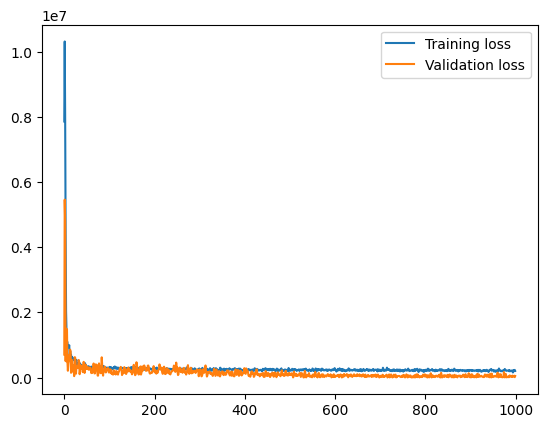

4/4 [==============================] - 0s 24ms/step


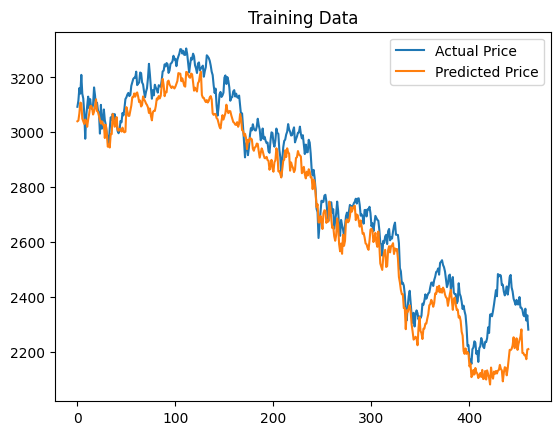

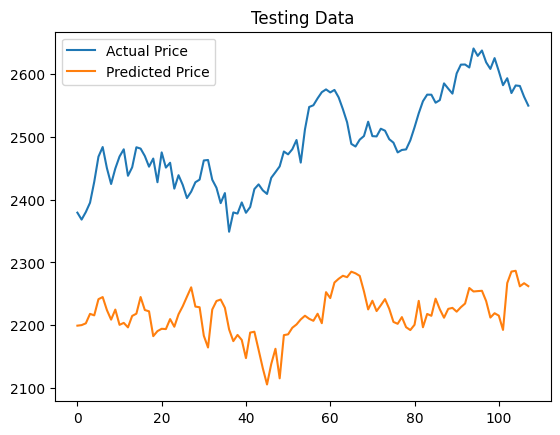

In [36]:
# 모델 생성
model = Sequential()
# model.add(Bidirectional(LSTM(units=1024, activation='relu', return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.1))
model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu'))
model.add(Dropout(0.3))
# model.add(GRU(units=16, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

loss = Huber()
optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h1')

# model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [37]:
# # 데이터 분할
# train_size = int(len(data) * 0.8)
# train_data, test_data = data[:train_size], data[train_size:]
# train_data_t, test_data_t = stock_data_close[:train_size], stock_data_close[train_size:]

# def create_dataset(dataset, data, look_back=10):
#     X, y = [], []
#     for i in range(len(data) - look_back):
#         X.append(dataset[i:(i + look_back)])
#         y.append(data[i + look_back])
#     return np.array(X), np.array(y)

# look_back = 10  # 몇 일 동안의 데이터를 사용할 것인지 설정

# trainX, trainY = create_dataset(train_data_t, train_data, look_back)
# testX, testY = create_dataset(test_data_t,test_data, look_back)
# print(trainX.shape)
# print(trainY.shape)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 8, 64)             5056      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 gru_40 (GRU)                (None, 4, 1024)           3348480   
                                                                 
 dropout_59 (Dropout)        (None, 4, 1024)           0         
                                                                 
 gru_41 (GRU)                (None, 4, 512)            2362368   
                                                                 
 dropout_60 (Dropout)        (None, 4, 512)            0         
                                                      

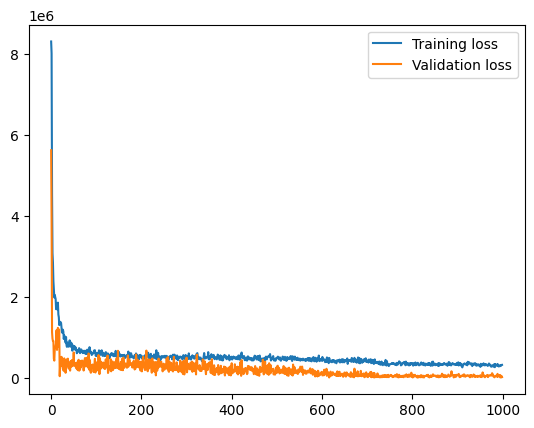

4/4 [==============================] - 0s 10ms/step


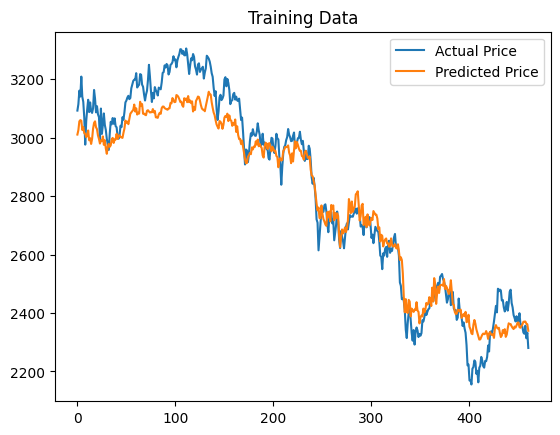

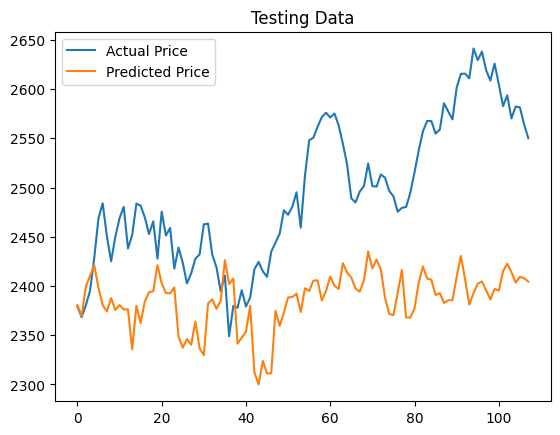

In [38]:
# 모델 생성
model = Sequential()
# model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


loss = Huber()
optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [39]:
# # 데이터 분할
# train_size = int(len(data) * 0.8)
# train_data, test_data = data[:train_size], data[train_size:]
# train_data_t, test_data_t = stock_data_close_only[:train_size], stock_data_close_only[train_size:]

# def create_dataset(dataset, data, look_back=10):
#     X, y = [], []
#     for i in range(len(data) - look_back):
#         X.append(dataset[i:(i + look_back)])
#         y.append(data[i + look_back])
#     return np.array(X), np.array(y)

# look_back = 10  # 몇 일 동안의 데이터를 사용할 것인지 설정

# trainX, trainY = create_dataset(train_data_t, train_data, look_back)
# testX, testY = create_dataset(test_data_t,test_data, look_back)
# print(trainX.shape)
# print(trainY.shape)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 8, 64)             5056      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 lstm_21 (LSTM)              (None, 4, 1024)           4460544   
                                                                 
 dropout_66 (Dropout)        (None, 4, 1024)           0         
                                                                 
 lstm_22 (LSTM)              (None, 4, 512)            3147776   
                                                                 
 dropout_67 (Dropout)        (None, 4, 512)            0         
                                                     

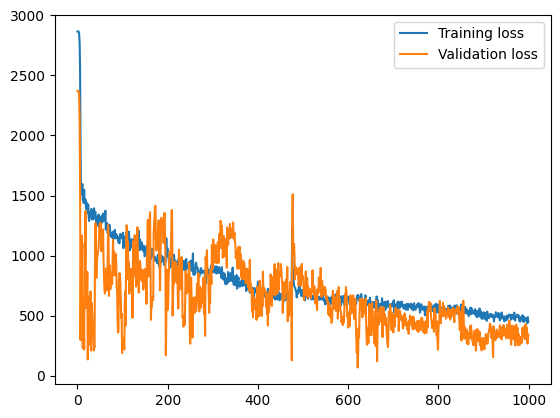

4/4 [==============================] - 0s 9ms/step


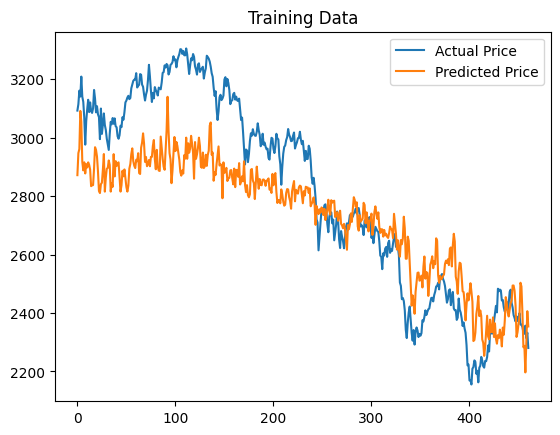

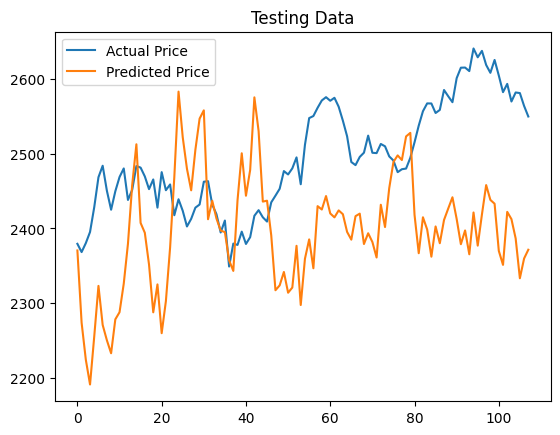

In [40]:
# 모델 생성
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 10, 1024)          4304896   
                                                                 
 dropout_73 (Dropout)        (None, 10, 1024)          0         
                                                                 
 lstm_29 (LSTM)              (None, 10, 512)           3147776   
                                                                 
 dropout_74 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_30 (LSTM)              (None, 10, 256)           787456    
                                                                 
 dropout_75 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_31 (LSTM)              (None, 10, 128)         

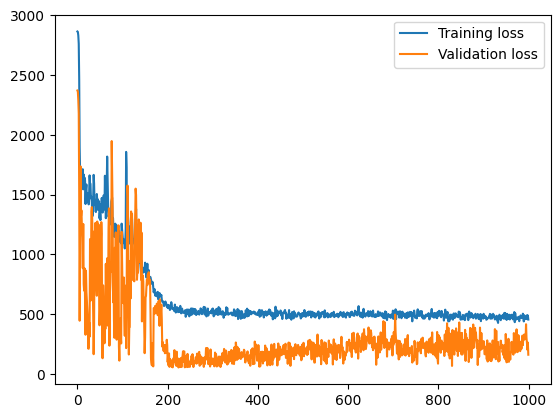

4/4 [==============================] - 0s 15ms/step


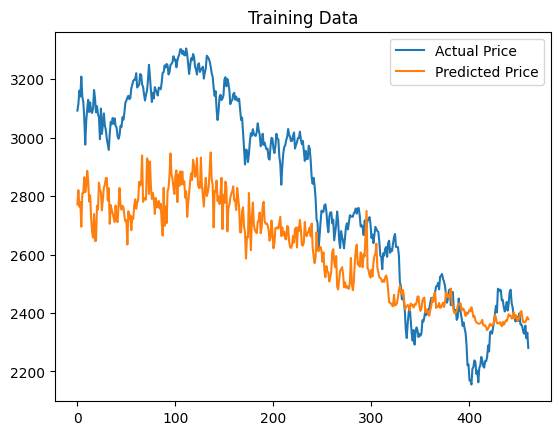

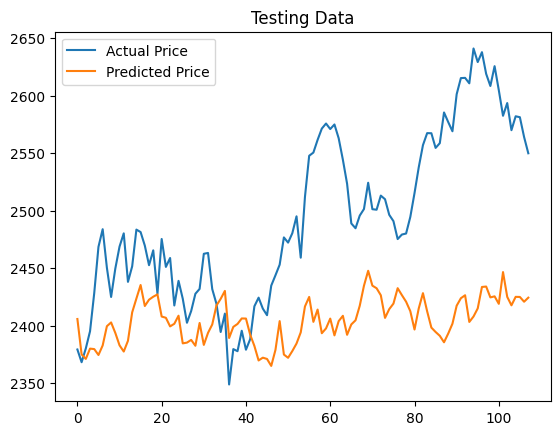

In [41]:
# 모델 생성
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [42]:
#양방향 lstm + 코드의 깊이 증가 및 유닛의 수 증가로 바꿔주는 코드


# model = Sequential()
# model.add(Bidirectional(LSTM(units=1024, activation='relu', return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2]))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=512, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=256, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=128, activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=64, activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=32, activation='relu',return_sequences=True))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=16, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(units=1))
# model.summary()

In [43]:


# model = Sequential()

# Add a Convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]))
# model.add(MaxPooling1D(pool_size=2)

# # Add LSTM layers
# model.add(LSTM(units=1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=512, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=256, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=128, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=64, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=32, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(units=16, activation='relu'))
# model.add(Dropout(0.1))

# # Add the output Dense layer
# model.add(Dense(units=1))

# model.summary()

In [44]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# filename = os.path.join('tmp', 'ckeckpointer.ckpt')
# checkpoint = ModelCheckpoint(filename,
#                              save_weights_only=True,
#                              save_best_only=True,
#                              monitor='val_loss',
#                              verbose=1)

# history = model.fit(train_data,
#                     validation_data=(test_data),
#                     epochs=50,
#                     callbacks=[checkpoint, earlystopping])

# model.load_weights(filename)

In [45]:
# # 모델 생성
# model = Sequential()
# model.add(Bidirectional(LSTM(units=1024, activation='relu', return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.1))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(units=512, activation='relu', return_sequences=True)))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=256, activation='relu', return_sequences=True)))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=128, activation='relu',return_sequences=True)))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=64, activation='relu',return_sequences=True)))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=32, activation='relu',return_sequences=True)))
# model.add(Dropout(0.1))
# model.add(Bidirectional(LSTM(units=16, activation='relu')))
# model.add(Dropout(0.1))
# model.add(Dense(units=1))
# model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# filename = os.path.join('tmp', 'ckeckpointer.ckpt')
# checkpoint = ModelCheckpoint(filename,
#                              save_weights_only=True,
#                              save_best_only=True,
#                              monitor='val_loss',
#                              verbose=1)

# # model.compile(optimizer='adam', loss='mean_squared_error')

# # 모델 학습
# history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
#           validation_split=0.1, verbose=2,callbacks=[checkpoint])

# model.save_weights('./lstm_weights.h3')

# model.load_weights(filename)

# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
# plt.show()

# # 예측
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# # 예측 결과 역 스케일링
# # trainPredict = trainPredict.detach().cpu().numpy()
# # trainPredict = scaler.inverse_transform(trainPredict)
# # trainY = trainY.detach().cpu().numpy()
# # trainY = scaler.inverse_transform([trainY])
# # testPredict = testPredict.detach().cpu().numpy()
# # testPredict = scaler.inverse_transform(testPredict)
# # testY = testY.detach().cpu().numpy()
# # testY = scaler.inverse_transform([testY])

# # 예측 시각화
# plt.plot(trainY, label='Actual Price')
# plt.plot(trainPredict, label='Predicted Price')
# plt.legend()
# plt.title('Training Data')
# plt.show()

# plt.plot(testY, label='Actual Price')
# plt.plot(testPredict, label='Predicted Price')
# plt.legend()
# plt.title('Testing Data')
# plt.show()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 8, 64)             5056      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 gru_47 (GRU)                (None, 1, 1024)           3348480   
                                                                 
 dropout_80 (Dropout)        (None, 1, 1024)         

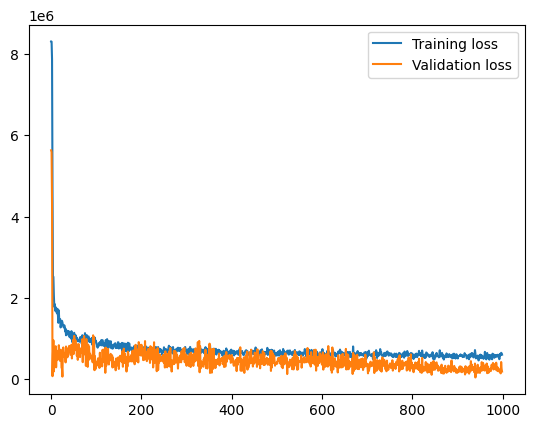

4/4 [==============================] - 0s 5ms/step


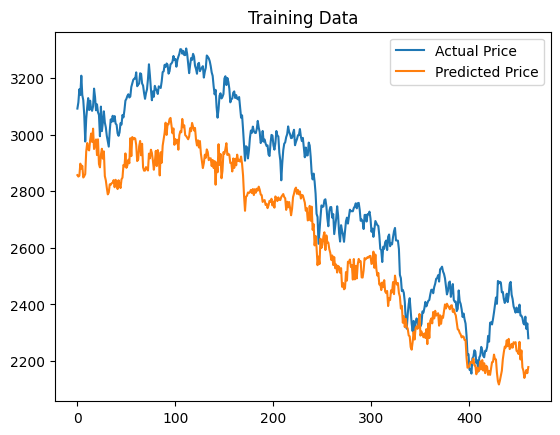

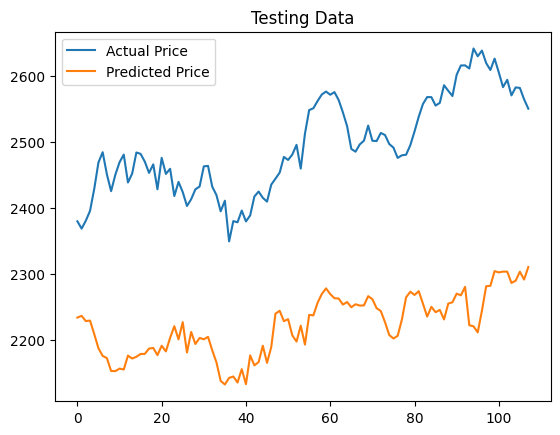

In [46]:
# 모델 생성
model = Sequential()
# model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


loss = Huber()
optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 8, 64)             5056      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 4, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 2, 64)             12352     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_35 (LSTM)              (None, 1, 1024)           4460544   
                                                                 
 dropout_87 (Dropout)        (None, 1, 1024)         

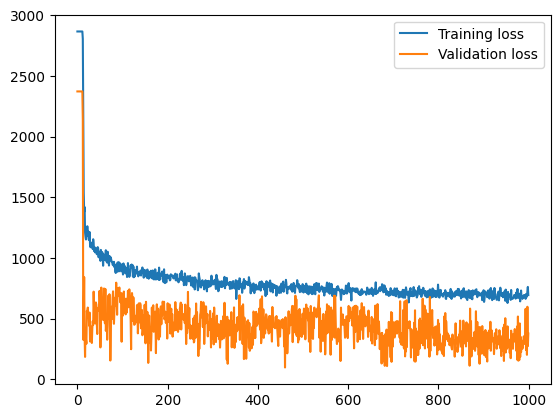

4/4 [==============================] - 0s 6ms/step


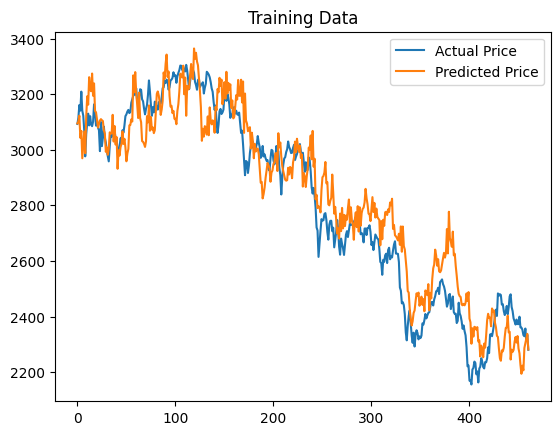

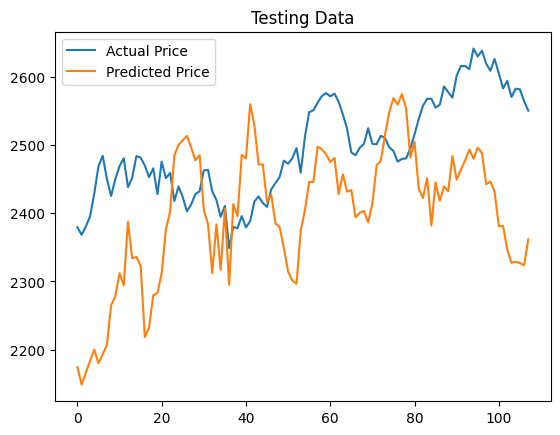

In [47]:
# 모델 생성
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./lstm_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 예측 결과 역 스케일링
# trainPredict = trainPredict.detach().cpu().numpy()
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = trainY.detach().cpu().numpy()
# trainY = scaler.inverse_transform([trainY])
# testPredict = testPredict.detach().cpu().numpy()
# testPredict = scaler.inverse_transform(testPredict)
# testY = testY.detach().cpu().numpy()
# testY = scaler.inverse_transform([testY])

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()